$\textbf{Introduction}$
In this exercise we will load in data and do quantile regression with the return data from 20 GSIB's. 
The banks are listed in the Table for Section 4.  THe control variables are listed in the same section.
We first read in the data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import warnings
warnings.filterwarnings("ignore")

In [2]:
TAB1 = pd.read_excel('McNYet_May2020_CovarData.xlsx')
date1 = TAB1.iloc[:,0]
StateVar = TAB1.iloc[:,1:10]
SharePrice = TAB1.iloc[:,10:30]
TraceVol = TAB1.iloc[:,30:50]
MarketCap = TAB1.iloc[:,50:70]

# Convert daily data to weekly data
index = range(6,len(StateVar),5)
index1 = range(1,len(StateVar),5)
StateVar1 = StateVar.iloc[index1,:]
StateVar1 = StateVar1.iloc[:-1,:]
# Replace any zeros with lagged values
MarketCap2 = MarketCap.iloc[index1,:]   

for i in range(2,len(MarketCap2.iloc[:,6])):
    if MarketCap2.iloc[i,6] == 0:
        MarketCap2.iloc[i,6] = MarketCap2.iloc[i-1, 6]

# Calculate weekly returns
Return = np.diff(np.log(MarketCap2), axis=0)
# Reverse the returns to negative returns
Return = -Return

([<matplotlib.axis.XTick at 0x7fdd5ef582e0>,
 [Text(0, 0, 'JPM'),
  Text(0, 0, 'MS'),
  Text(0, 0, 'MFG'),
  Text(0, 0, 'RBC'),
  Text(0, 0, 'RBS'),
  Text(0, 0, 'SAN'),
  Text(0, 0, 'STT'),
  Text(0, 0, 'SMFG'),
  Text(0, 0, 'UBS'),
  Text(0, 0, 'WFC')])

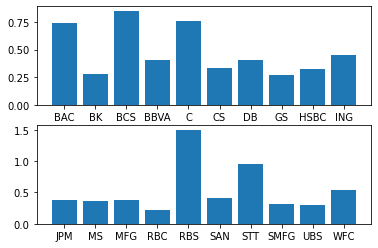

In [3]:
BankNames1 = ['BAC','BK','BCS','BBVA', 'C', 'CS', 'DB', 'GS', 'HSBC', 'ING','JPM', 'MS', 'MFG', 'RBC', 'RBS', 'SAN', 'STT', 'SMFG', 'UBS,' 'WFC']
MaxRet = np.max(Return, axis=0)
a1 = plt.subplot(211)
names = ['BAC','BK','BCS','BBVA', 'C', 'CS', 'DB', 'GS', 'HSBC', 'ING']
plt.bar(range(10), MaxRet[:10])
plt.xticks(list(range(10)), names)
a2 = plt.subplot(212)
names1 = ['JPM', 'MS', 'MFG', 'RBC', 'RBS', 'SAN', 'STT', 'SMFG', 'UBS', 'WFC']
plt.bar(range(10), MaxRet[10:])
plt.xticks(list(range(10)), names1)

As we can see, some of the banks took heavy losses in market capitalization, particularly the RBS, but so did C (Citicorp) and MS.  The question for us is the following:  are the heavy losers also the biggest transmitters of risk to the rest of the financial system?

In [3]:
# Calculate weighted return for the market
MarketCap2 = MarketCap2.iloc[1:,:]
SMC2 = np.sum(MarketCap2,axis=1)
RatioMC = MarketCap2.div(SMC2, axis=0)
AveReturn1 = -Return*RatioMC
WeightedReturn = np.sum(AveReturn1,axis=1)

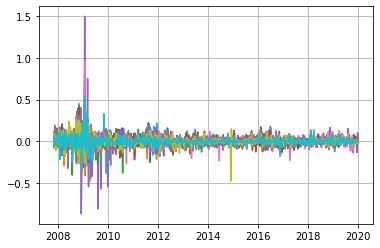

In [5]:
date2 = date1.iloc[index1]
date2 = date2.iloc[1:]

# Plot weighted market returns
plt.plot(date2, Return)
plt.grid()

In [4]:
VARq05 = []
VARq50 = []
DCOVAR = []
for i in range(20):
    RETURN = Return
    MARKETCAP2 = MarketCap2
    RETURN = np.delete(RETURN, i, 1)
    MARKETCAP2 = MARKETCAP2.drop(MARKETCAP2.columns[i], axis=1)
    WRETURN1 = RETURN*MARKETCAP2
    SRETURN1 = np.sum(MARKETCAP2,axis=1)
    SYSTEMRET = WRETURN1.div(SRETURN1, axis=0) 
    SYSTEMRET = np.sum(SYSTEMRET,axis=1)
    xx = np.append(Return[:,i].reshape(-1,1), StateVar1, axis=1)
    yy = SYSTEMRET
    
    tau1= .95
    tau2 = .50
    model1 = QuantReg(yy, xx).fit(q=tau1)
    model2 = QuantReg(yy, xx).fit(q=tau2)
   
    VARq05.append(model1.predict(xx))
    VARq50.append(model2.predict(xx))
    DCOVAR.append(VARq05[i]-VARq50[i])

In [5]:
# Plot the Dcovar for bank BAC, DB
plt.plot(date2, DCOVAR[1])
plt.plot(date2, DCOVAR[7])
plt.title('\u0394COVAR')
plt.grid()
plt.legend('BAC','DB')

NameError: name 'date2' is not defined

In [6]:
#  Do the same for an expanded Quantile regression:
VARq05 = []
VARq50 = []
DCOVAR2 = []
for i in range(20):
    RETURN = Return
    MARKETCAP2 = MarketCap2
    RETURN = np.delete(RETURN, i, 1)
    MARKETCAP2 = MARKETCAP2.drop(MARKETCAP2.columns[i], axis=1)
    WRETURN1 = RETURN*MARKETCAP2
    SRETURN1 = np.sum(MARKETCAP2,axis=1)
    SYSTEMRET = WRETURN1.div(SRETURN1, axis=0) 
    SYSTEMRET = np.sum(SYSTEMRET,axis=1)
    xx = np.append(Return[:,i].reshape(-1,1), StateVar1, axis=1)
    # We add in a cubic expansion for the i-th bank return and controls
    xxx = np.append(xx, np.append(np.power(xx,2), np.power(xx,3), axis=1), axis=1)
    yy = SYSTEMRET

    tau1= .95
    tau2 = .50
    model1 = QuantReg(yy, xxx).fit(q=tau1)
    model2 = QuantReg(yy, xxx).fit(q=tau2)
    
    VARq05.append(model1.predict(xxx))
    VARq50.append(model2.predict(xxx))
    DCOVAR2.append(VARq05[i]-VARq50[i])

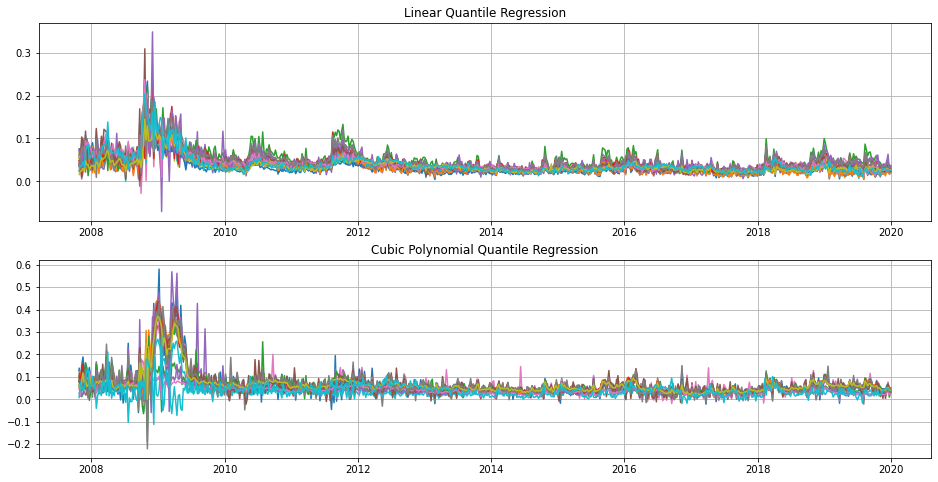

In [9]:
#  Compare the DCOVAR from linear and cubic polynomial regression
plt.figure(figsize=(16,8))
plt.subplot(211); plt.plot(date2, np.array(DCOVAR).T); plt.title('Linear Quantile Regression'); plt.grid();
plt.subplot(212); plt.plot(date2, np.array(DCOVAR2).T); plt.title('Cubic Polynomial Quantile Regression'); plt.grid(); 

We see that the ranges and the dynamics are pretty close.

In [7]:
BankNames = ['BAC','BK','BCS','BBVA', 'C', 'CS', 'DB', 'GS', 'HSBC', 'ING','JPM', 'MS', 'MFG', 'RBC', 'RBS', 'SAN', 'STT', 'SMFG', 'UBS,' 'WFC']
# We will use the data first from the Cubic Polynomial Regression
Maxval = np.max(DCOVAR2, axis=1)

([<matplotlib.axis.XTick at 0x7fdd61a81df0>,
 [Text(0, 0, 'JPM'),
  Text(0, 0, 'MS'),
  Text(0, 0, 'MFG'),
  Text(0, 0, 'RBC'),
  Text(0, 0, 'RBS'),
  Text(0, 0, 'SAN'),
  Text(0, 0, 'STT'),
  Text(0, 0, 'SMFG'),
  Text(0, 0, 'UBS'),
  Text(0, 0, 'WFC')])

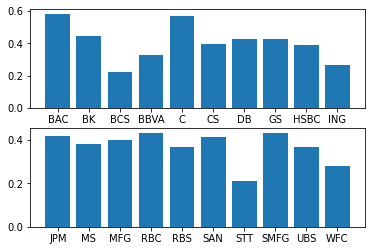

In [11]:
names = ['BAC','BK','BCS','BBVA', 'C', 'CS', 'DB', 'GS', 'HSBC', 'ING']
a1 = plt.subplot(211)
plt.bar(range(10), Maxval[:10])
plt.xticks(list(range(10)), names)
a2 = plt.subplot(212)
names1 = ['JPM', 'MS', 'MFG', 'RBC', 'RBS', 'SAN', 'STT', 'SMFG', 'UBS', 'WFC']
plt.bar(range(10), Maxval[10:])
plt.xticks(list(range(10)), names1)

([<matplotlib.axis.XTick at 0x2232e9bc848>,
 <a list of 10 Text xticklabel objects>)

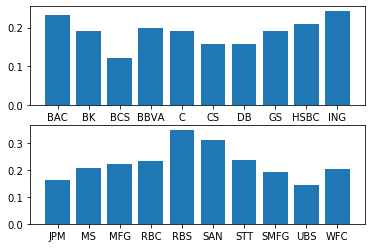

In [8]:
Maxval = np.max(DCOVAR, axis=1)
a1 = plt.subplot(211)
names = ['BAC','BK','BCS','BBVA', 'C', 'CS', 'DB', 'GS', 'HSBC', 'ING']
plt.bar(range(10), Maxval[:10])
plt.xticks(list(range(10)), names)
a2 = plt.subplot(212)
names1 = ['JPM', 'MS', 'MFG', 'RBC', 'RBS', 'SAN', 'STT', 'SMFG', 'UBS', 'WFC']
plt.bar(range(10), Maxval[10:])
plt.xticks(list(range(10)), names1)

In the following section we will examine the Neural Net approximaiton to quantile regression to see if the results are robust to more complex specificaiton.